
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:
X = ha.drop("cp", axis = 1)
y = ha["cp"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include = np.number))
    ],
  remainder = "passthrough")

knn_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn", KNeighborsClassifier())
    ]
    )



cross_val_score(knn_pipeline, X, y, cv=5, scoring='roc_auc_ovo').mean()




0.5775534607005195

In [ ]:
tree_pipeline = Pipeline(
    [
        #("preprocessing", ct),
        ("tree", DecisionTreeClassifier(max_depth = 2))
    ]
)

cross_val_score(tree_pipeline, X, y, cv=5, scoring='roc_auc_ovo').mean()

0.607999937154349

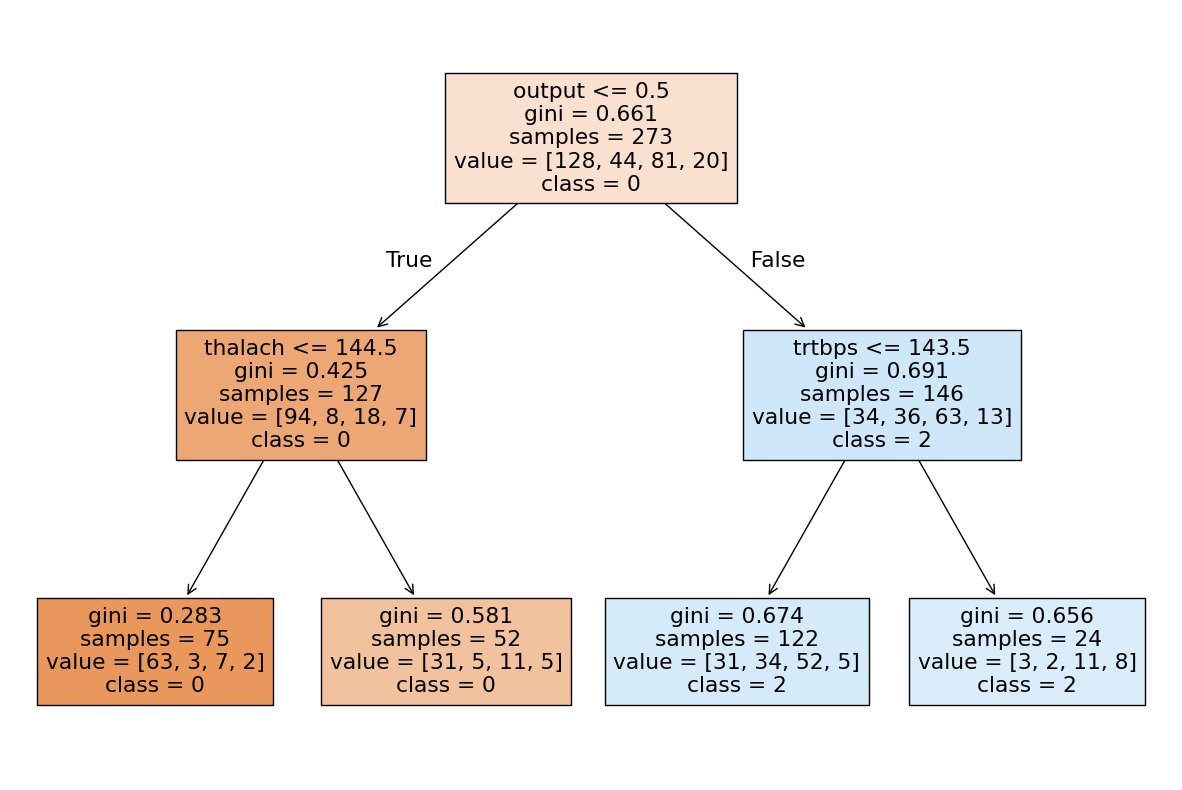

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_pipeline.fit(X,y)
tree_model = tree_pipeline.named_steps['tree']
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
plot_tree(tree_model, feature_names=X.columns, class_names=['0', '1', '2', '3'], filled=True)
plt.show()

Interpretation:

The decision tree begins by splitting on output <= 0.5, dividing the 273 samples into two branches. The left branch, where output <= 0.5 is true, contains 127 samples with a Gini index of 0.425 and is dominated by Class 0 (94 samples). This branch further splits on thalach <= 144.5, creating two nodes: the left child has 75 samples (majority Class 0, Gini = 0.283), while the right child has 52 samples (still majority Class 0 but with more impurity, Gini = 0.581). The right branch of the root node, where output > 0.5, contains 146 samples with a higher Gini index of 0.691 and is dominated by Class 2 (63 samples). This branch splits on trtbps <= 143.5, producing two child nodes: the left child has 122 samples (majority Class 2, Gini = 0.674), and the right child has 24 samples (majority Class 2, Gini = 0.656). Each split reduces impurity and refines the predictions for the majority class.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_pipeline = Pipeline(
    [
        ("preprocessing", ct),  # Your existing ColumnTransformer
        ("lda", LinearDiscriminantAnalysis())  # Replace DecisionTreeClassifier with LinearDiscriminantAnalysis
    ]
)

# Now you can perform cross-validation with the LDA pipeline
cross_val_score(lda_pipeline, X, y, cv=5, scoring='roc_auc_ovo').mean()

0.6652907920646892

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
ha['cp_is_3'] = ha['cp'] == 3
ha.head()
X = ha.drop(columns=['cp', 'cp_is_3'])
y = ha['cp_is_3']

In [ ]:
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("Logistic_regression", LogisticRegression())]
)


cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()

y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c0 = f1_score(y,y_pred)
f1_c0
#what is an F1 score?
#Represents a model's performance, with higher values indicating better overall accuracy and balance between precision and recall.

0.0

In [ ]:
ha['cp_is_2'] = ha['cp'] == 2
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2
0,63,1,3,145,233,0,150,1,True,False
1,37,1,2,130,250,1,187,1,False,True
2,56,1,1,120,236,1,178,1,False,False
3,57,0,0,120,354,1,163,1,False,False
4,57,1,0,140,192,1,148,1,False,False


In [ ]:
X = ha.drop(columns=['cp', 'cp_is_2', 'cp_is_3'])
y = ha['cp_is_2']

y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c2 = f1_score(y,y_pred)
f1_c2

0.2127659574468085

In [ ]:
ha['cp_is_0'] = ha['cp'] == 0
X = ha.drop(columns=['cp', 'cp_is_0','cp_is_2', 'cp_is_3'])
y = ha['cp_is_0']

y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c0 = f1_score(y,y_pred)
f1_c0

0.7159533073929961

In [ ]:
ha['cp_is_1'] = ha['cp'] == 1
X = ha.drop(columns=['cp', 'cp_is_1','cp_is_0','cp_is_2', 'cp_is_3'])
y = ha['cp_is_1']

y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c1 = f1_score(y,y_pred)
f1_c1

0.0

Based on the F1 score the best OvR did at predicting was for 0.


## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
filtered_ha = ha[ha['cp'].isin([0, 1])]

filtered_ha.head()
X = filtered_ha.drop(columns=['cp','cp_is_2', 'cp_is_3', 'cp_is_1', 'cp_is_3', 'cp_is_0'])
y = filtered_ha['cp']


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("Logistic_regression", LogisticRegression(max_iter = 10000))]
)

cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()


0.8376709401709401

In [ ]:
filtered_ha2 = ha[ha['cp'].isin([0, 2])]


X = filtered_ha2.drop(columns=['cp','cp_is_2', 'cp_is_3', 'cp_is_1', 'cp_is_3', 'cp_is_0'])
y = filtered_ha2['cp']


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("Logistic_regression", LogisticRegression(max_iter = 10000))]
)

cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()


0.7511029411764706

In [ ]:
filtered_ha3 = ha[ha['cp'].isin([0, 3])]


X = filtered_ha3.drop(columns=['cp','cp_is_2', 'cp_is_3', 'cp_is_1', 'cp_is_3', 'cp_is_0'])
y = filtered_ha3['cp']


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("Logistic_regression", LogisticRegression(max_iter = 10000))]
)

cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()

0.7412307692307692

These models do the best at predicting between 0 and 1 based on ROC_AUC.